Imports

In [2]:
''' imports '''

import numpy as np
import pandas as pd

from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter
import os, re, logging

%matplotlib widget
#import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize

import pickle, random

# density clustering using HDBSCAN* algorithm
#import hdbscan

# dimensionality reduction using UMAP
#import umap

''' torch imports '''

import torch, math

from torch import nn
from torch import optim
from torch.distributions import Normal

import glob
from PIL import Image
import matplotlib.animation as animation

import json

#import torchsde, torchcde



''' init shjnn dev env '''

# set auto reload imported modules
%load_ext autoreload
%autoreload 2

import os
# create save and gif folders if they dont exist already
if not os.path.exists('./saves/'):
    os.makedirs('./saves/')
if not os.path.exists('./gifs/'):
    os.makedirs('./gifs/')

# add location to path
import sys
sys.path.append('../libs/')

import shjnn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda')

Dataloader


In [2]:
def dataloader(data_out):

    """
    Load raw data from file, map parameters to dimension data, compile lists of parameters, and generate full single-sample dataset.
    args: None
    returns: trajs, times, y
    """

    ## load raw data from file

    # open binary file for reading
    with open('{}/{}'.format('../run/', 'raw-full'), 'rb') as file:

        # load pickled data storage array
        db = pickle.load(file)


    ## parameter mappings to dimension data

    val_map = {
        # sample id to thickness in nm
        'thickness': {'source': 'sample',
                    '12': 160, '16': 160, '21': 160, '33': 160, '45': 160, '58': 160, },
        # intensity in uJ
        'intensity': {'source': 'int',
                    'dark': 0., '32uJ': 32., '10uJ': 10., '3uJ': 3., '1uJ': 1., '03uJ': .3},
        # voltage in V
        'voltage': {'source': 'vlt',
                    '05V': .5, '0V': 0., '15V': 1.5, '1V': 1., '2V': 2.},
        # delay time in log10(s)
        'delay': {'source': 'del',
                '100ns': 1e-7, '100us': 1e-4, '10ms': 1e-2, '10us': 1e-5, '1ms': 1e-3, '1us': 1e-6,
                '200ns': 2e-7, '200us': 2e-4, '20ms': 2e-2, '20us': 2e-5, '2ms': 2e-3, '2us': 2e-6,
                '500ns': 5e-7, '500us': 5e-4, '50ms': 5e-2, '50us': 5e-5, '5ms': 5e-3, '5us': 5e-6,
                },
    }

    ''' generate properties data '''

    # iterate nodes in database
    for node in db[:]:
        
        props = {}
        
        # iterate value mapping
        for key, value in val_map.items():
        
            # check node params for value
            if value['source'] in node['params'].keys():
                
                # map param to prop value
                props[key] = value[ node['params'][ value['source'] ] ]
                            
            else:
                # store zero for no match
                props[key] = 0.
                
        # store props in node
        node['props'] = props
    ''' generate properties data '''

    # iterate nodes in database
    for node in db[:]:
        
        props = {}
        
        # iterate value mapping
        for key, value in val_map.items():
        
            # check node params for value
            if value['source'] in node['params'].keys():
                
                # map param to prop value
                props[key] = value[ node['params'][ value['source'] ] ]
                            
            else:
                # store zero for no match
                props[key] = 0.
                
        # store props in node
        node['props'] = props

    ''' compile lists params '''

    # compile list samples
    smpls = sorted(list(set([ _['params']['sample'] for _ in db ])))
    print( 'smpls', smpls )

    # compile list voltages
    vlts = sorted(list(set([ _['props']['voltage'] for _ in db ])))
    print( 'vlts', vlts )

    # compile list voltages
    ints = sorted(list(set([ _['props']['intensity'] for _ in db ])))
    print( 'ints', ints )

    # complete list delays
    #dels = sorted(list(set([ _['props']['delay'] for _ in db ])))[1::]
    # restricted delay set
    dels = sorted(list(set([ _['props']['delay'] for _ in db ])))[1::3]
    print( 'dels', dels )

    
    ''' get full single-sample dataset '''

    # select transient conditions
    _smpl = '33'
    #_int = '10uJ'
    #_vlt = '15V'
    #_del = '10us'

    _db = [ n for n in db if
        n['params']['sample'] == _smpl and
        n['props']['delay'] != 0.
        #n['params']['int'] == _int and
        #n['params']['vlt'] == _vlt and
        #n['params']['del'] == _del
        ]

    print(len(_db))


    # initialise figure
    fig = plt.figure(figsize = (8,6))
    #axs = [[ fig.add_subplot(v,h,i+1) for i in range(h*v) ] for h,v in [(2,1)]][0]
    axs = [[ fig.add_subplot(v,h,i+1) for i in range(h*v) ] for h,v in [(1,1)]][0]

    # colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(_db[::10])); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'viridis')

    # zero baseline
    axs[0].plot([1e-8, 1e-4], [0,0], '--k')


    for i, n in enumerate(_db[::10]):
        
        # get time axis
        t = n['data'][:,0]
        d = n['data'][:,1]/50.
        #d0 = dark0['data'][:,1]#/50.
        #ds = d-d0

        c = smap.to_rgba(i)

        #print(light['params']['del'])

        #np.power(10,val_map['delay'][light['params']['del']])
        #sub = np.vstack([dark[:,0], (light[:,1] - dark[:,1])/50. ]).T

        #l = light['data'][:,1]#/50.
        #s = l-d

        # calculate current transient, illuminated less dark transient, voltage over 50 Ohm res
        #a = (light[:,1] - dark[:,1])/50.

        # smooth and calculate derivatives
        a = savgol_filter(x = d, window_length = 5, polyorder = 1, deriv = 0)

        _ds = 10
        
        # plot data
        axs[0].plot(t[::_ds], d[::_ds], '.', alpha = 0.2, color = c, linewidth = 2)
        axs[0].plot(t[::_ds], a[::_ds], '-', alpha = 0.44, color = c, linewidth = 1, label = ''.format())


        #axs[1].plot(t, da, '-', alpha = 0.7, color = c, linewidth = 1, label = '{}'.format(light['params']['int']))

            
    # format plots
    for i in range(len(axs)):
        axs[i].set_xscale('log')
        axs[i].set_xlim(1.0e-8, 1.0e-4)
        #axs[i].set_xlim(2.0e-7, 1.0e-4)
        
        #axs[i].set_ylim(0., 1.0e-2)
        axs[i].set_xlabel('Extraction Time (s)')
        axs[i].set_ylabel('Extracted Charge (A)')
        #axs[i].legend(title='Illumination')
        
    plt.tight_layout()
    plt.show()

    j = np.where(_db[0]['data'][:,0] > 1e-9)[0]

    # get log time steps, shift decay start to zero
    #ts = np.log10(db[0]['data'][:,0][::_ds])
    ts = np.transpose( np.stack([ [ 
        #n['data'][:,0][::_ds], # time
        #n['data'][j,0][::_ds]
        
        np.log10(n['data'][j,0][::_ds])+6.7,
    ]
    #for n in _db ]), (2,0,1))
        for n in _db ]), (0,2,1))


    # stack raw data and env vars, time first
    #d = np.transpose( np.stack([ [ n['data'][:,1][::_ds], 
    d = np.transpose( np.stack([ [ 
        #np.log10(n['data'][j,0][::_ds]), # time
        
        n['data'][j,1][::_ds]*1e2, # response, scale to ~one
        #np.log10(n['data'][j,0][::_ds])+6.6,
        
    #np.ones(len(ts))* np.log10(n['props']['intensity']),
    #np.ones(len(ts))* n['props']['voltage']/10,
    #np.ones(len(ts))* np.abs(np.log10(n['props']['delay']))/10,
    ]
    #for n in _db ]), (2,0,1))
        for n in _db ]), (0,2,1))

    print(ts.shape, d.shape)

    ''' compile env. labels '''

    # stack raw data and env vars, time first
    y = np.stack([ [ 
    n['props']['intensity'],
    n['props']['voltage'],
    n['props']['delay'],
    ]
        for n in _db ])

    y.shape

    # compile trajectories, time as tensors, push to device
    trajs = torch.Tensor(d).to(device)
    times = torch.Tensor(ts).to(device)

    print(len(d), d[0].shape, ts[0].shape)

    data_out['trajs'] = trajs
    data_out['times'] = times
    data_out['y'] = y


Initialise Model

In [3]:
def init_model(model_params):
    """
        inits models - always to CPU.
        args: model_params
        return: model_params (updated)
    """
    latent_dim = model_params['latent_dim']
    nhidden = model_params['nhidden']
    rnn_nhidden = model_params['rnn_nhidden']
    obs_dim = model_params['obs_dim']
    lr = model_params['lr']
    n_batch = model_params['n_batch']

    func, rec, dec, optim, device = shjnn.init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr, device = 'cpu')
    loss: list = []
    epochs = 0
    device

    model_params['func'] = func
    model_params['rec'] = rec
    model_params['dec'] = dec
    model_params['optim'] = optim
    model_params['device'] = device
    model_params['loss'] = loss
    model_params['epochs'] = epochs
    model_params['loss'] = loss
    model_params['MSE_loss'] = loss
    model_params['KL_loss'] = loss

    return model_params

Training loop

In [4]:
def training_loop(n_epochs, model_params, dataset):
    ''' run training loop with save 
        args: n_epochs, model_params, dataset
        return: model_params (updated)
    '''

    

    # beta for beta latent dissentanglement
    #beta = 4.
    # beta = .01

    # update learning rate
    # lr = 1e-3

    lr = model_params['lr']
    n_batch = model_params['n_batch']
    beta = model_params['beta']

    optim = model_params['optim']


    for g in optim.param_groups:
        g['lr'] = lr

    # get data
    trajs = dataset['trajs']
    times = dataset['times']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    device = model_params['device']

    # run training for epochs, return loss
    _epochs, _loss = shjnn.train(func, rec, dec, optim, trajs[:], times[:], n_epochs, n_batch, device, beta)

    # update loss, epochs
    model_params['loss'] += _loss
    model_params['epochs'] += _epochs

    return model_params

def done_training(model_params):
    """ check if training is done
        args: model_params
        return: bool
    """
    return model_params['epochs'] >= model_params['total_epochs_train']

input adaptive update functions here

In [5]:
# parameter update functions (runs during runs and updatesand )

def update_beta(model_params, epochs):
    model_params['beta'] = model_params['beta']

def update_lr(model_params, epochs):
    model_params['lr'] = model_params['lr']

def update_n_epochs(model_params, epochs):
    return

def update_params(model_params, epochs):
    update_beta(model_params, epochs)
    update_lr(model_params, epochs)
    update_n_epochs(model_params, epochs)

Data processing and interpretation

In [6]:
def plot_training_loss(model_params, save=False, split=False):
    ''' plot training loss '''
    if split:
        MSE_loss = model_params['MSE_loss']
        KL_loss = model_params['KL_loss']

        k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
        #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
        ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]


        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in MSE_loss], '-b', label = 'MSE loss', alpha = 0.3)
        ax[1].plot([_+1e1 for _ in KL_loss], '-b', label = 'KL loss', alpha = 0.3)

        # smooth loss
        train_MSE_loss = np.abs( savgol_filter(MSE_loss, 13, 3) )
        train_KL_loss = np.abs( savgol_filter(KL_loss, 13, 3) )

        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in train_MSE_loss], '-b', alpha = 0.8)
        ax[1].plot([_+1e1 for _ in train_KL_loss], '-b', alpha = 0.8)


        # format and display figure
        plt.yscale('log')
        #plt.xscale('log')

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend()
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph_split.png")
    else:
        # get loss
        loss = model_params['loss']

        # initialise figure
        k = 1; _w = 5; _h = 2*k; fig = plt.figure(figsize = (_w, _h))
        #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
        ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]


        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in loss], '-b', label = 'training loss', alpha = 0.3)

        # smooth loss
        train_loss = np.abs( savgol_filter(loss, 13, 3) )

        # plot original and predicted trajectories
        ax[0].plot([_+1e1 for _ in train_loss], '-b', alpha = 0.8)


        # format and display figure
        plt.yscale('log')
        #plt.xscale('log')

        plt.xlabel('Iterations')
        plt.ylabel('Loss')

        plt.legend()
        plt.tight_layout()
        plt.show()

        if save:
            folder = model_params['folder']
            save_folder = f"{folder}/loss_graph/"
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)
            plt.savefig(f"{save_folder}/loss_graph.png")



In [7]:
def display_random_fit(model_params, dataset, show=True, save=False, random_samples=True):
    ''' random assess model fit '''


    # get data
    trajs = dataset['trajs']
    times = dataset['times']
    y = dataset['y']

    # get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    device = model_params['device']
    epoch = model_params['epochs']
    

    # initialise figure
    k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
    #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
    ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]

    # generate inference function
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

    # select data
    j = list(range(len(trajs)))
    if random_samples:
        random.shuffle(j)

    # downsample
    j = j[::30]

    # build colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(j)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'brg')

    # iterate over transients
    for _,i in enumerate(j):
        
        # get colour
        c = smap.to_rgba(_)
        
        # send mini-batch to device
        traj = trajs[i].view(1, *trajs[i].size()).to(device)
        
        #_time = np.linspace(-7.8, -4.2, 1000)#/10
        #_time = np.linspace(-6.5+6.6, -4.2+6.6, 1000)#/10
        
        _time = np.linspace(0, 2.5, 1000)#/10
        
        #_time = np.linspace(-7., -4.2, 1000)
        #_time = np.logspace(-7.8, -4.2, 1000)
        
        #_time = np.logspace(0, 1.7, 20)
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(traj, time)

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]
        
        #print(pred_x.shape, pred_z[0,0,:])
        
        _traj = trajs[i].cpu()
        _t = times[i].cpu()

        for l in range(k):
            u = 0
            
            #ax[k].set_ylim(-.8, .8)
            sc_ = 50*1e2/1e3
            
            # plot original and predicted trajectories
            ax[l].plot(_t, _traj[:, l+u]/sc_, '.', alpha = 0.6, color = c)
            ax[l].plot(_time - 1.0, pred_x[:, l+u]/sc_, '-', label = '{:.1f} $\mu J$, {:.1f} V, {:.0e} s'.format(y[i][0], y[i][1], y[i][2]),
                    linewidth = 2, alpha = 0.4, color = c)

            
    plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
    plt.ylabel('Charge [mA]')
    # tile includes epoch number, learning rate atnd beta
    plt.title('Epoch: {}, lr: {:.1e}, beta: {:.1e}'.format(epoch, model_params['lr'], model_params['beta']))

    #plt.xscale('log')
    plt.legend(loc='upper right', title='Intensity, Bias, Delay')

    plt.tight_layout()

    if show:
        plt.show()
    if save:
        #save as a png]
        #todo: change
        folder = model_params['folder']
        #if saves folder does not exist create it
        if not os.path.exists(folder):
            os.makedirs(folder)
        fig.savefig(folder + '/training_epoch_{}.png'.format(epoch), dpi=300)

def save_random_fit(model_params, dataset, random_samples=True):
    display_random_fit(model_params, dataset, show=False, save=True, random_samples=random_samples)

def clear_saves():
    ''' clear all save files in saves directory '''
    import os
    import glob
    #todo change??
    files = glob.glob('saves/*')
    for f in files:
        os.remove(f)

Saving and recording Data

In [8]:
def compile_learning_gif(model_params, display=True):
    # compile gif from png in saves folder
    # set read destinatino here
    folder = model_params['folder']
    glob_target = folder + '/*.png'
    print(glob_target)
    files = sorted(glob.glob(glob_target))
    image_array = []

    for my_file in files:
        
        image = Image.open(my_file)
        image_array.append(image)

    print('image_arrays shape:', np.array(image_array).shape)

    # Create the figure and axes objects
    fig, ax = plt.subplots()

    # Set the initial image
    im = ax.imshow(image_array[0], animated=True)

    def update(i):
        im.set_array(image_array[i])
        return im, 

    # Create the animation object
    animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)

    # Show the animation
    plt.show()

    # animation_fig.save("gifs/animated_GMM.gif")

    
    #to html5 video using pillow
    if not os.path.exists(folder + "/gifs/"):
        os.makedirs(folder + "/gifs/")
    animation_fig.save(folder + "/gifs/learning_pattern.gif", writer="pillow")

    if (display):
        video = animation_fig.to_html5_video()
        html = display.HTML(video)
        display.display(html) 


In [9]:
def save_model_params(model_params):
    #save model params as json file
    folder = model_params['folder']
    epoch = model_params['epochs']
    model_params_save = {
        # hyper params

        
        'nhidden': model_params['nhidden'],
        'rnn_nhidden': model_params['rnn_nhidden'],
        'obs_dim': model_params['obs_dim'],

        'latent_dim': model_params['latent_dim'],
        'lr': model_params['lr'],
        'n_batch': model_params['n_batch'],
        'beta': model_params['beta'],

        # training params
        'total_epochs_train': model_params['total_epochs_train'],
        'epochs_per_train': model_params['epochs_per_train'],
        'epochs': model_params['epochs'], # a record of the epochs
        'loss': model_params['loss'], 

        #labels
        'name': model_params['name'],
        'desc': model_params['desc'],
        'folder': model_params['folder'],
    }

    if not os.path.exists(folder + '/model'):
        os.makedirs(folder + '/model')
    with open(folder + f'/model/model_params_epoch_{epoch}.json', 'w') as fp:
        json.dump(model_params_save, fp)

def load_model_params():
    #load model params from json file
    folder = model_params['folder']
    epoch = 5   #enter your desired epoch to extract here
    with open(folder + f'/model/model_params_{epoch}.json', 'r') as fp:
        model_params = json.load(fp)
        init_model(model_params)
    return model_params

In [10]:
def save_model(model_params):
    #save model params as json file
    folder = model_params['folder']
    epoch = model_params['epochs']
    if not os.path.exists(folder + '/model'):
        os.makedirs(folder + '/model')

    # save model
    #load model params
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    loss = model_params['loss']
    epochs = model_params['epochs']
    folder = model_params['folder']
    path = folder + f'/model/save_model_ckpt_{epoch}.pth'
    shjnn.save_state(path, func, rec, dec, optim, loss, epochs)

def load_model(model_params):
    #load model params from json file. Overwrite model params.
    folder = ""
    epoch = 5   #enter your desired epoch to extract here
    path = folder + f'/model/save_model_ckpt_{epoch}.pth'
    #dev = 'gpu'
    dev = 'cpu'
    shjnn.load_state(path, model_params['func'], model_params['rec'], dec = model_params['dec'], optim = model_params['optim'], loss = model_params['loss'], epochs = model_params['epochs'], dev = dev)

In [11]:
def sweep_latent_dynamics(model_params, dataset):
    for j in range(model_params['latent_dim']):
        sweep_latent_dynamic(model_params, dataset, j)

def sweep_latent_dynamic(model_params, dataset, latent_dim_number):
    ''' get z0 prediction of complete dataset '''

    # get data
    trajs = dataset['trajs']
    times = dataset['times']
    y = dataset['y']

    #get model
    func = model_params['func']
    rec = model_params['rec']
    dec = model_params['dec']
    optim = model_params['optim']
    device = model_params['device']
    epoch = model_params['epochs']
    latent_dims = model_params['latent_dim']

    # generate inference function
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)

    # select data
    j = list(range(len(trajs)))
    #random.shuffle(j)

    Z = []

    Zz = []

    for i in j[::]:
        
        # send mini-batch to device
        traj = trajs[i].view(1, *trajs[i].size()).to(device)
        
        _time = np.linspace(0, 2.5, 1000)#/10
        
        #_time = np.linspace(-7., -4.2, 1000)
        #_time = np.logspace(-7.8, -4.2, 1000)
        
        #_time = np.logspace(0, 1.7, 20)
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(traj, time)
        
        Z.append(pred_z[0, 0, ...].detach().numpy())
        
        Zz.append(pred_z[0, ...].detach().numpy())

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]
        
    Z = np.stack(Z)
    Zz = np.stack(Zz)

    print(Z.shape, Zz.shape)

    ''' sweep latent dynamics '''

    # initialise figure
    k = trajs[0].shape[-1]; _w = 7; _h = 4*k; fig = plt.figure(figsize = (_w, _h))
    #fig.canvas.layout.width = '{}in'.format(_w); fig.canvas.layout.height= '{}in'.format(_h)
    ax = [ [ fig.add_subplot(j,1,i) for i in range(1,j+1) ] for j in [k] ][0]
    # setup ax for each latent dim


    # generate inference function
    #infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'traj', _sample=False)
    infer_step = shjnn.make_infer_step(func, rec, dec, optim, device, _input = 'latent')

    # set z dim to sweep
    j = latent_dim_number
    # for j in range(latent_dims):

    # set range over latent vector
    rr = 3
    _ = np.linspace(-rr,rr,10)

    # colourmap
    cnorm  = colors.Normalize(vmin = 0, vmax = len(_)); smap = cmx.ScalarMappable(norm = cnorm, cmap = 'cividis')

    # iterate over latent vector range
    for i in range(len(_)):
        _z = _[i]
        c = smap.to_rgba(i)

        # set init latent to mean of dataset or zeros
        _z0 = np.expand_dims(np.mean(Z, 0),0)
        #_z0 = np.expand_dims(np.zeros(Z.shape[-1]),0)
        
        # update latent vector for variation
        _z0[...,j] += _z
        #print(_z0)
        
        z0 = torch.Tensor(_z0).to(device)

        # define time axis
        _time = np.linspace(0, 2.5, 1000)#/10
        time = torch.Tensor(_time).to(device)

        # perform inference step for prediciton
        pred_x, pred_z = infer_step(z0, time)

        # return prediction to cpu
        pred_x = pred_x.cpu().numpy()[0]

        # plot predicted trajectories
        ax[0].plot(_time, pred_x[:, 0], '-', label = 'z{}, $\mu$ {:.1f} + {:.1f}'.format(j, np.mean(Z, 0)[j],_z), alpha = 0.6, color = c, linewidth = 2)

            
    plt.xlabel('Time [10$^{-7}$ + -log$_{10}(t)$ s]')
    plt.ylabel('Charge [mA]')

    plt.hlines(0., -.1, 2.6, colors = 'k', linestyle = '--', alpha = 0.5)
    plt.xlim(-.1,2.6)
            
    plt.legend()
        
    #plt.xscale('log')
    plt.tight_layout()
    plt.show()

    folder = model_params['folder']
    #if saves folder does not exist create it
    if not os.path.exists(folder + '/latent_dims'):
        os.makedirs(folder + '/latent_dims')
    fig.savefig(folder + f'/latent_dims/epoch_{epoch}_dim_{latent_dim_number}.png', dpi=300)

Main

- always run #configure initial state here!

smpls ['12', '16', '21', '33', '45', '58']
vlts [0.0, 0.5, 1.0, 1.5, 2.0]
ints [0.0, 0.3, 1.0, 3.0, 10.0, 32.0]
dels [1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01]
150


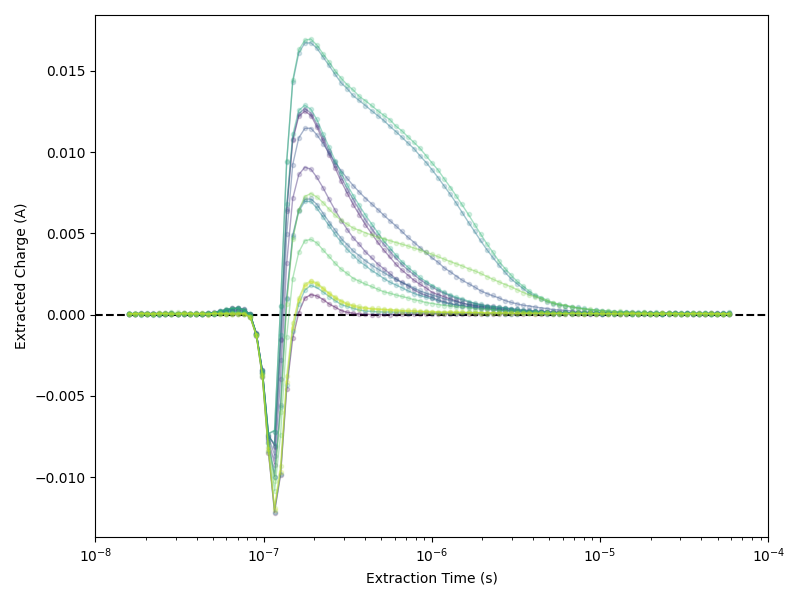

(150, 100, 1) (150, 100, 1)
150 (100, 1) (100, 1)


In [12]:
# configure initial state here.


# dictionary of hyper params
dataset = {
    'trajs': None,
    'times': None,
    'y': None,
}

model_params = {
    # hyper params

    
    'nhidden': 128,
    'rnn_nhidden': 32,
    'obs_dim': 0,

    'latent_dim': 8,
    'lr': 1e-3,
    'n_batch': 16,
    'beta': .001,

    'optim': None,
    'device': None,
    'func': None,
    'rec': None,
    'dec': None,

    # training params
    'total_epochs_train': 50,
    'epochs_per_train': 5,
    'epochs': 0, # a record of the epochs
    'loss': 0,  #loss = total loss = KL_loss + MSE loss
    'MSE_loss': 0,
    'KL_loss': 0,

    #labels
    'name': "default",
    'desc': "default run",
    'folder': "saves"
}
dataloader(dataset)
trajs = dataset['trajs']

obs_dim = trajs[0].size()[1]
model_params['obs_dim'] = obs_dim
# latent_dim, nhidden, rnn_nhidden, obs_dim, lr, n_batch, beta = get_hyper_params(trajs)
# model_params = get_hyper_params(dataset, model_params)
# # func, rec, dec, optim, device, loss, epochs = init_model(latent_dim, nhidden, rnn_nhidden, obs_dim, n_batch, lr)
# model_params = init_model(model_params)
# training_loop(func, rec, dec, optim, trajs, times, n_batch, device, beta)

#clear saves folder
# clear_saves()





Vanilla way of running code

In [13]:
def run_and_save(model_params, dataset, grid_search=False, grid_search_name="default"):

    import time


    name = model_params['name']
    desc = model_params['desc']

    #replace all spaces with _
    name = name.replace(" ", "_")
    desc = desc.replace(" ", "_")

    # create folder based on time, name and description
    timestr = time.strftime("%Y%m%d-%H%M%S")
    folder = './saves/' + desc + '_' + name + '_' + timestr
    if grid_search:
        folder = f'./saves/grid_seach/{grid_search_name}/' + desc + '_' + name + '_' + timestr
        #make parent dirs
        # if not os.path.exists(f'./saves/grid_seach'):
        #     os.makedirs(f'./saves/grid_seach')
        # if not os.path.exists(f'./saves/grid_seach/{grid_search_name}'):
        #     os.makedirs(f'./saves/grid_seach/{grid_search_name}')
    model_params['folder'] = folder
    if not os.path.exists(folder):
        os.makedirs(folder)

    train_epochs = model_params['epochs_per_train']
    init_model(model_params)
    while not done_training(model_params):
        training_loop(train_epochs, model_params, dataset)
        print("epochs printout:   ")
        print(model_params['epochs'])
        print("loss printout: ")
        print(model_params['loss'])
        update_params(model_params, model_params['epochs'])
        save_random_fit(model_params, dataset, random_samples=False)
        save_model(model_params)
    save_model_params(model_params)
    plot_training_loss(model_params, save=True)
    # plot_training_loss(model_params, save=True, split=True)
    compile_learning_gif(model_params, display=False)

    return model_params


Execute a grid search

In [14]:
def grid_search(model_params):
    learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
    n_batches = [16]
    latent_dims = [1, 2, 4, 8, 16]
    betas = [.001, 0.5, 1, 2, 4]


    # beta never above 4  done
    # latent_dims : 1, 2, 4, 8, 16   done
    # learning rats: 1e-2, 5e-3, 1e-3, 5e-4, 1e-4    done
    # ode solver struggles to "converge" when its already close. implement time/loss wrapper that stops the running when reached and output what epoch it reached the limit.

    #check both MSE and KL. KL should be around 1, MSE is dependent on the data. Try to normalise MSE so that it is around KL. feat. loss is MSE
    # check if kl loss is before or after beta.
    # could plot the KL loss and the MSE loss on the same graph to compare and see how its training.

    # add training gif for each run. done
    # save model checkpoints.   done
    

    # learning_rates = [5e-3, 1e-3]
    # n_batches = [16]
    # latent_dims = [8]
    # betas = [.001, 4,]

    run_description = "search2"

    data_record = {"learning rate": [],
                    "n_batch": [],
                    "latent_dim": [],
                    "beta": [],
                    "lowest_loss": []}
    
    loss_record = {"learning rate": [],
                   "n_batch": [],
                   "latent_dim": [],
                   "beta": [],
                   "loss": []}

    total_runs = len(learning_rates) * len(n_batches) * len(latent_dims) * len(betas)
    excel_folder_created = False
    excel_folder_path = ""

    
    for lr in learning_rates:
        for n_batch in n_batches:
            for latent_dim in latent_dims:
                for beta in betas:
                    model_params['lr'] = lr
                    model_params['n_batch'] = n_batch
                    model_params['latent_dim'] = latent_dim
                    model_params['beta'] = beta
                    model_params['desc'] = f"lr_{lr}_nb_{n_batch}_ld_{latent_dim}_b_{beta}"

                    try:
                        run_and_save(model_params, dataset, grid_search=True, grid_search_name=run_description)
                    except AssertionError:
                        model_params["loss"].append(-1)
                    # handle assertion error
                    

                    #write summary data to excel sheet
              

                    

                    # append information to data_record
                    data_record["learning rate"].append(lr)
                    data_record["n_batch"].append(n_batch)
                    data_record["latent_dim"].append(latent_dim)
                    data_record["beta"].append(beta)
                    loss = model_params['loss']
                    lowest_loss = min(loss)
                    data_record["lowest_loss"].append(lowest_loss)

                    # append information to loss_record
                    loss_record["learning rate"].append(lr)
                    loss_record["n_batch"].append(n_batch)
                    loss_record["latent_dim"].append(latent_dim)
                    loss_record["beta"].append(beta)
                    loss_record["loss"].append(loss)

                    model_params["epochs"] = 0
                    model_params["loss"] = 0

    if not excel_folder_created:
    #create excel sheet
        folder = model_params['folder']
        excel_folder_path = f'{folder}/../excel_output'
        if not os.path.exists(excel_folder_path):
            os.makedirs(excel_folder_path)
        excel_folder_created = True

    #write to excel
    df = pd.DataFrame(data_record)
    sheet = pd.ExcelWriter(f'{excel_folder_path}/summary.xlsx')
    df.to_excel(sheet)
    sheet.close()

    lf = pd.DataFrame(loss_record)
    loss_sheet = pd.ExcelWriter(f'{excel_folder_path}/loss_record.xlsx')
    lf.to_excel(loss_sheet)
    loss_sheet.close()




intialising model on device: cpu
Epoch 1: Total Loss 147934.484, KL Loss 0.01, Feat. Loss 147934.48
Epoch 1: Total Loss 211134.172, KL Loss 0.01, Feat. Loss 211134.17
Epoch 1: Total Loss 153064.141, KL Loss 0.01, Feat. Loss 153064.14
Epoch 1: Total Loss 157023.625, KL Loss 0.01, Feat. Loss 157023.62
Epoch 1: Total Loss 268509.781, KL Loss 0.02, Feat. Loss 268509.78
Epoch 1: Total Loss 186359.266, KL Loss 0.03, Feat. Loss 186359.27
Epoch 1: Total Loss 180034.172, KL Loss 0.03, Feat. Loss 180034.17
Epoch 1: Total Loss 127055.391, KL Loss 0.03, Feat. Loss 127055.39
Epoch 1: Total Loss 157850.750, KL Loss 0.03, Feat. Loss 157850.75
Epoch 1 : 10593.11, 9865.67
Epoch 2: Total Loss 222659.125, KL Loss 0.04, Feat. Loss 222659.12
Epoch 2: Total Loss 172788.562, KL Loss 0.04, Feat. Loss 172788.56
Epoch 2: Total Loss 245397.016, KL Loss 0.03, Feat. Loss 245397.02
Epoch 2: Total Loss 145596.719, KL Loss 0.03, Feat. Loss 145596.72
Epoch 2: Total Loss 138825.578, KL Loss 0.03, Feat. Loss 138825.58
E

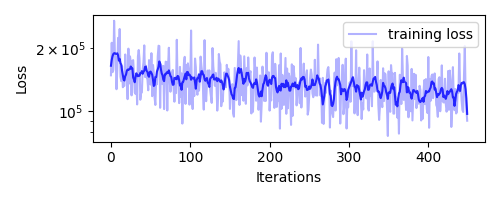

./saves/grid_seach/search2/lr_0.01_nb_16_ld_1_b_0.001_default_20240213-220234/*.png
image_arrays shape: (10, 1200, 2100, 4)


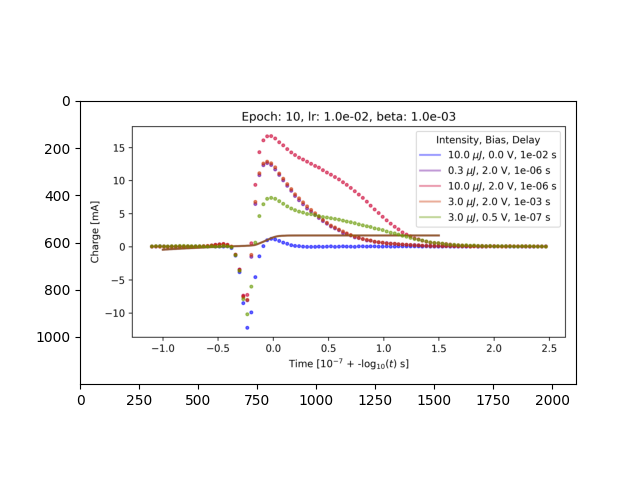

intialising model on device: cpu
Epoch 1: Total Loss 235834.609, KL Loss 0.00, Feat. Loss 235834.61
Epoch 1: Total Loss 191892.250, KL Loss 0.01, Feat. Loss 191892.25
Epoch 1: Total Loss 155160.703, KL Loss 0.00, Feat. Loss 155160.70
Epoch 1: Total Loss 129624.391, KL Loss 0.00, Feat. Loss 129624.39
Epoch 1: Total Loss 192319.984, KL Loss 0.00, Feat. Loss 192319.98
Epoch 1: Total Loss 151733.000, KL Loss 0.01, Feat. Loss 151733.00
Epoch 1: Total Loss 186814.453, KL Loss 0.01, Feat. Loss 186814.45
Epoch 1: Total Loss 185583.922, KL Loss 0.01, Feat. Loss 185583.92
Epoch 1: Total Loss 126832.938, KL Loss 0.01, Feat. Loss 126832.94
Epoch 1 : 10371.98, 11599.00
Epoch 2: Total Loss 202097.125, KL Loss 0.01, Feat. Loss 202097.12
Epoch 2: Total Loss 124583.797, KL Loss 0.01, Feat. Loss 124583.80
Epoch 2: Total Loss 152902.281, KL Loss 0.01, Feat. Loss 152902.28
Epoch 2: Total Loss 142479.812, KL Loss 0.02, Feat. Loss 142479.81
Epoch 2: Total Loss 166229.531, KL Loss 0.02, Feat. Loss 166229.53


In [30]:
grid_search(model_params);

intialising model on device: cpu
Epoch 1: Total Loss 238280.375, KL Loss 0.08, Feat. Loss 238280.38
Epoch 1: Total Loss 172236.422, KL Loss 0.08, Feat. Loss 172236.42
Epoch 1: Total Loss 169437.266, KL Loss 0.08, Feat. Loss 169437.27
Epoch 1: Total Loss 175391.734, KL Loss 0.08, Feat. Loss 175391.73
Epoch 1: Total Loss 195042.688, KL Loss 0.08, Feat. Loss 195042.69
Epoch 1: Total Loss 149288.672, KL Loss 0.09, Feat. Loss 149288.67
Epoch 1: Total Loss 161532.438, KL Loss 0.09, Feat. Loss 161532.44
Epoch 1: Total Loss 142045.578, KL Loss 0.10, Feat. Loss 142045.58
Epoch 1: Total Loss 170056.219, KL Loss 0.11, Feat. Loss 170056.22
Epoch 1 : 10488.74, 10628.51
Epoch 2: Total Loss 190250.078, KL Loss 0.11, Feat. Loss 190250.08
Epoch 2: Total Loss 114368.891, KL Loss 0.12, Feat. Loss 114368.89
Epoch 2: Total Loss 163633.750, KL Loss 0.13, Feat. Loss 163633.75
Epoch 2: Total Loss 152463.859, KL Loss 0.15, Feat. Loss 152463.86
Epoch 2: Total Loss 140149.062, KL Loss 0.16, Feat. Loss 140149.06


{'nhidden': 128,
 'rnn_nhidden': 32,
 'obs_dim': 1,
 'latent_dim': 8,
 'lr': 0.001,
 'n_batch': 16,
 'beta': 0.001,
 'optim': Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 'device': 'cpu',
 'func': LatentODEfunc(
   (elu): ELU(alpha=1.0, inplace=True)
   (fci): Linear(in_features=8, out_features=128, bias=True)
   (fc1): Linear(in_features=128, out_features=128, bias=True)
   (fco): Linear(in_features=128, out_features=8, bias=True)
 ),
 'rec': RecognitionRNN(
   (i2h): Linear(in_features=33, out_features=32, bias=True)
   (h2o): Linear(in_features=32, out_features=16, bias=True)
 ),
 'dec': Decoder(
   (relu): ReLU(inplace=True)
   (fc1): Linear(in_features=8, out_features=128, bias=True)
   (fc2): Linear(in_features=128, out_features=1, bias=True)
 ),
 'total_epochs_train': 10,
 'epochs_per_train':

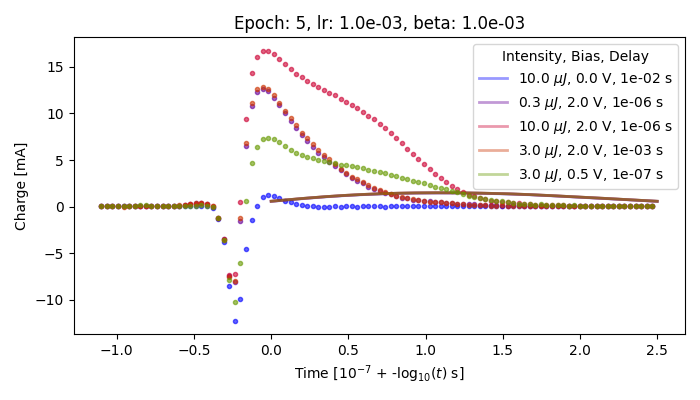

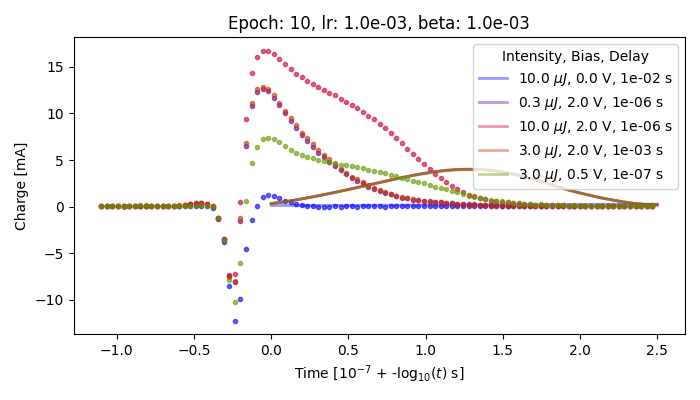

In [20]:
run_and_save(model_params, dataset)

Execute data processing code.

In [4]:
%ls

 Volume in drive C has no label.
 Volume Serial Number is A6C2-DA53

 Directory of c:\vscode\python\TOR-2024\raymond-tor-dtml\nbks

06/02/2024  01:14 AM    <DIR>          .
22/01/2024  01:07 PM    <DIR>          ..
25/01/2024  02:33 AM    <DIR>          gifs
15/02/2024  12:20 AM         2,730,177 parameter_tuning.ipynb
05/02/2024  05:45 PM           497,155 ray.ipynb
13/02/2024  10:06 PM    <DIR>          saves
24/01/2024  06:54 PM         2,194,354 trce-lode-rebuild.ipynb
17/01/2024  11:28 PM           200,893 trce-process-updt.ipynb
               4 File(s)      5,622,579 bytes
               4 Dir(s)  234,465,689,600 bytes free


In [3]:
#interpret grid search results

dataframe1 = pd.read_excel(".\saves\grid_seach\search1\excel_output\summary.xlsx")
 
# print(dataframe1)
data_dict = dataframe1.to_dict()

size = len(data_dict['Unnamed: 0'])
indexes = data_dict['Unnamed: 0']
learning_rates = data_dict['learning rate']
n_batchs = data_dict['n_batch']
latent_dims = data_dict['latent_dim']
betas = data_dict['beta']
lowest_loss = data_dict['lowest_loss']



minimum_loss = min(lowest_loss.values())
minimum_loss_index = list(lowest_loss.values()).index(minimum_loss)
print(f"minimum_loss: {minimum_loss} at index: {minimum_loss_index} with learning rate: {learning_rates[minimum_loss_index]}, n_batch: {n_batchs[minimum_loss_index]}, latent_dim: {latent_dims[minimum_loss_index]}, beta: {betas[minimum_loss_index]}")

lowest_loss_sorted = sorted(list(lowest_loss.values()))[:5]      #gets the 5 lowest loss values
lowest_loss_index = [list(lowest_loss.values()).index(i) for i in lowest_loss_sorted]  #gets the indexes of the 5 lowest loss values
print("\n Analysing the 5 lowest values: \n")
for i in lowest_loss_index:
    print(f"loss: {lowest_loss[i]} at index: {i} with learning rate: {learning_rates[i]}, n_batch: {n_batchs[i]}, latent_dim: {latent_dims[i]}, beta: {betas[i]}")

print("\n analysing average loss of each characterstic \n")

#get unique values of each characteristic
unique_learning_rates = list(set(learning_rates.values()))
unique_n_batchs = list(set(n_batchs.values()))
unique_latent_dims = list(set(latent_dims.values()))
unique_betas = list(set(betas.values()))\

best_learning_rate = unique_learning_rates[0]
max_loss = max(lowest_loss.values())

temp_min = max_loss
temp_avg = max_loss
best_learning_rate_min = 0
best_learning_rate_avg = 0
for lr in unique_learning_rates:
    lr_losses = [lowest_loss[i] for i in range(size) if learning_rates[i] == lr]
    print(f"\nanalysing learning rate: {lr}\n")
    minimum = min(lr_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(lr_losses, 25)}")
    mean = sum(lr_losses)/len(lr_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(lr_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_learning_rate_min = lr
    if mean < temp_avg:
        temp_avg = mean
        best_learning_rate_avg = lr
print(f"\nbest learning rate for minimum loss: {best_learning_rate_min}")
print(f"best learning rate for average loss: {best_learning_rate_avg}\n")
    
temp_min = max_loss
temp_avg = max_loss
best_n_batch_min = 0
best_n_batch_avg = 0
for nb in unique_n_batchs:
    nb_losses = [lowest_loss[i] for i in range(size) if n_batchs[i] == nb]
    print(f"\nanalysing n_batch: {nb}\n")
    minimum = min(nb_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(nb_losses, 25)}")
    mean = sum(nb_losses)/len(nb_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(nb_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_n_batch_min = nb
    if mean < temp_avg:
        temp_avg = mean
        best_n_batch_avg = nb
print(f"\nbest n_batch for minimum loss: {best_n_batch_min}")
print(f"best n_batch for average loss: {best_n_batch_avg}\n")

temp_min = max_loss
temp_avg = max_loss
best_latent_dim_min = 0
best_latent_dim_avg = 0
for ld in unique_latent_dims:
    ld_losses = [lowest_loss[i] for i in range(size) if latent_dims[i] == ld]
    print(f"\nanalysing latent_dim: {ld}\n")
    minimum = min(ld_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(ld_losses, 25)}")
    mean = sum(ld_losses)/len(ld_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(ld_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_latent_dim_min = ld
    if mean < temp_avg:
        temp_avg = mean
        best_latent_dim_avg = ld
print(f"\nbest latent_dim for minimum loss: {best_latent_dim_min}")
print(f"best latent_dim for average loss: {best_latent_dim_avg}\n")


temp_min = max_loss
temp_avg = max_loss
best_beta_min = 0
best_beta_avg = 0
for b in unique_betas:
    b_losses = [lowest_loss[i] for i in range(size) if betas[i] == b]
    print(f"\nanalysing beta: {b}\n")
    minimum = min(b_losses)
    print(f"minimum loss: {minimum}")
    print(f"25th percentile: {np.percentile(b_losses, 25)}")
    mean = sum(b_losses)/len(b_losses)
    print(f"average loss: {mean}")
    print(f"75th percentile loss: {np.percentile(b_losses, 75)}")
    if minimum < temp_min:
        temp_min = minimum
        best_beta_min = b
    if mean < temp_avg:
        temp_avg = mean
        best_beta_avg = b
print(f"\nbest beta for minimum loss: {best_beta_min}")
print(f"best beta for average loss: {best_beta_avg}\n")








minimum_loss: 8813.390625 at index: 20 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.001

 Analysing the 5 lowest values: 

loss: 8813.390625 at index: 20 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.001
loss: 13821.625 at index: 9 with learning rate: 0.01, n_batch: 16, latent_dim: 2, beta: 4.0
loss: 14612.8681640625 at index: 16 with learning rate: 0.01, n_batch: 16, latent_dim: 8, beta: 0.5
loss: 15689.7685546875 at index: 46 with learning rate: 0.005, n_batch: 16, latent_dim: 16, beta: 0.5
loss: 16143.001953125 at index: 21 with learning rate: 0.01, n_batch: 16, latent_dim: 16, beta: 0.5

 analysing average loss of each characterstic 


analysing learning rate: 0.01

minimum loss: 8813.390625
25th percentile: 17082.22265625
average loss: 36204.0650390625
75th percentile loss: 51540.1328125

analysing learning rate: 0.005

minimum loss: 15689.7685546875
25th percentile: 18697.85546875
average loss: 33086.3885546875
75th percentile loss: 23377.257812

In [ ]:
# change summary avg loss -> 25%
# summary to include what the bads are.
# take the interesting examples/trends and look into them
# implement MSE/KL graphs.

# implement time-cutoff and run interesting trends at 200 epochs
# tweak/look into a or f tolerance

# start working on report. 


# loss: 13821.625 at index: 9 with learning rate: 0.01, n_batch: 16, latent_dim: 2, beta: 4.0

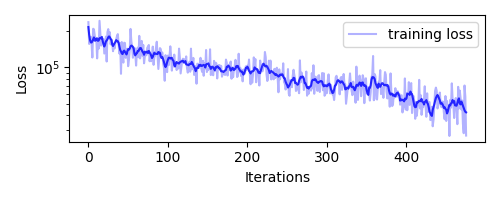

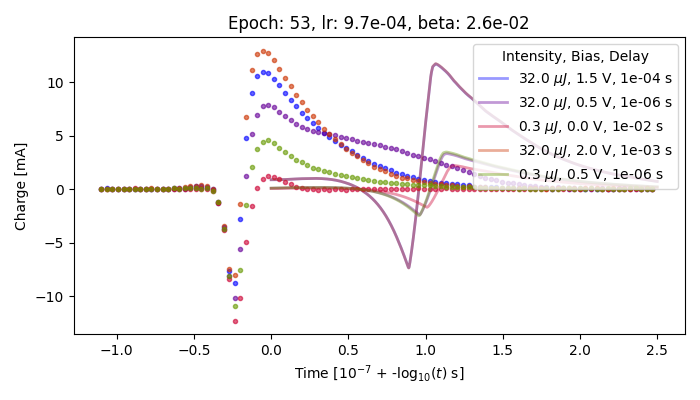

In [67]:
plot_training_loss(model_params)
display_random_fit(model_params, dataset)

(150, 8) (150, 1000, 8)


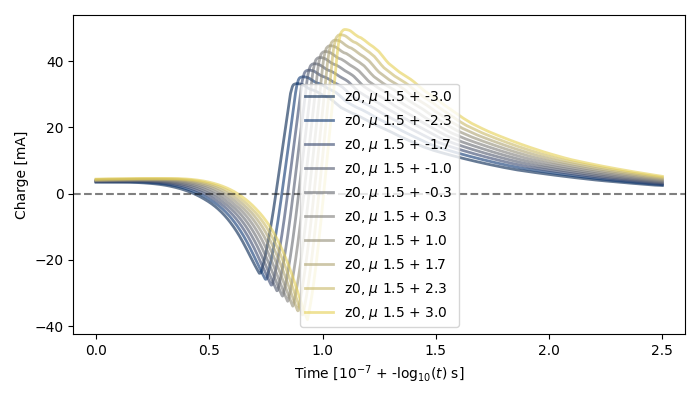

(150, 8) (150, 1000, 8)


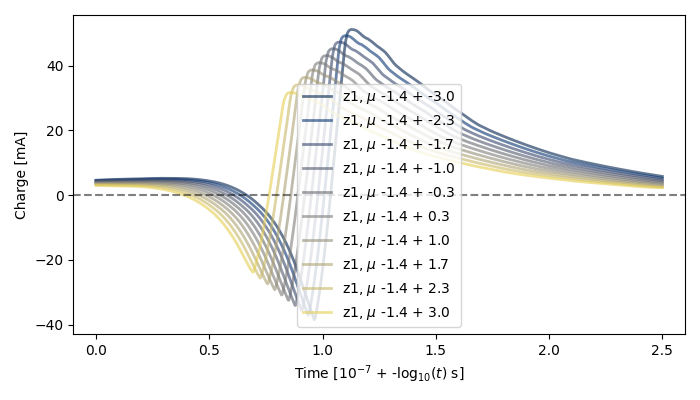

(150, 8) (150, 1000, 8)


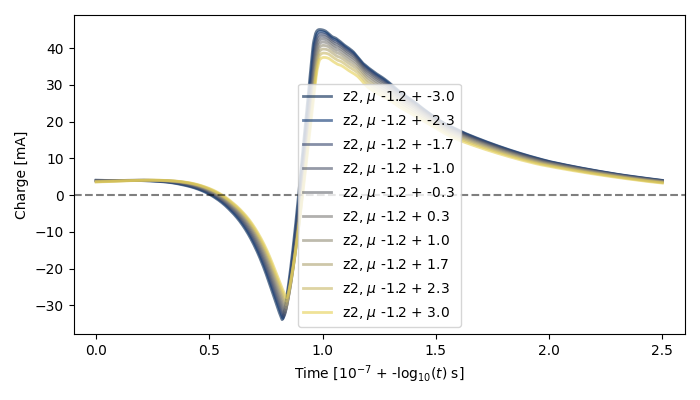

(150, 8) (150, 1000, 8)


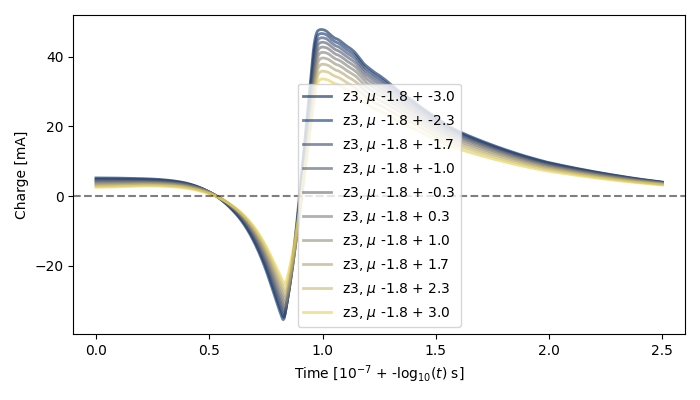

(150, 8) (150, 1000, 8)


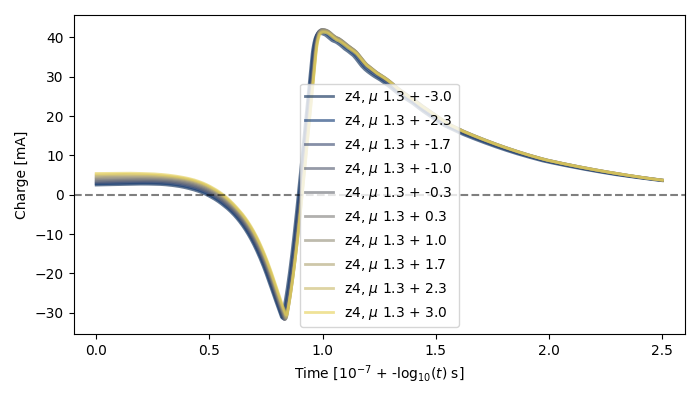

(150, 8) (150, 1000, 8)


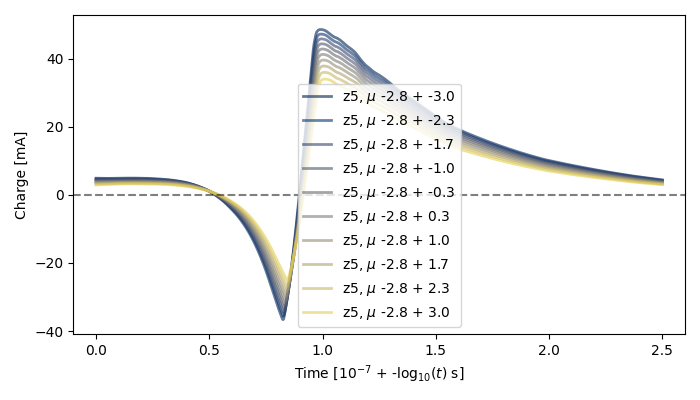

(150, 8) (150, 1000, 8)


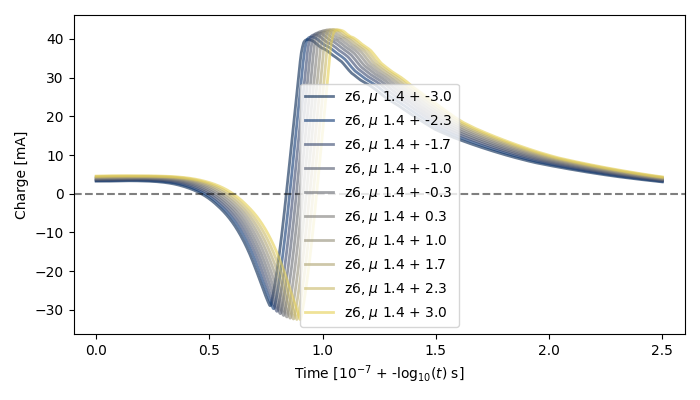

(150, 8) (150, 1000, 8)


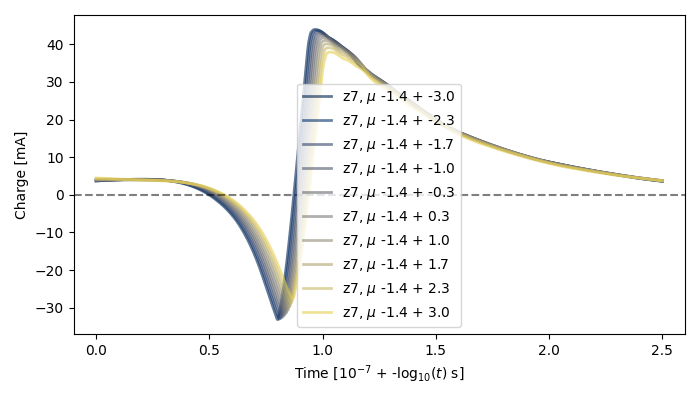

In [89]:
sweep_latent_dynamics(model_params, dataset)

./saves/default_run_default_20240202-174805/*.png
image_arrays shape: (10, 1200, 2100, 4)


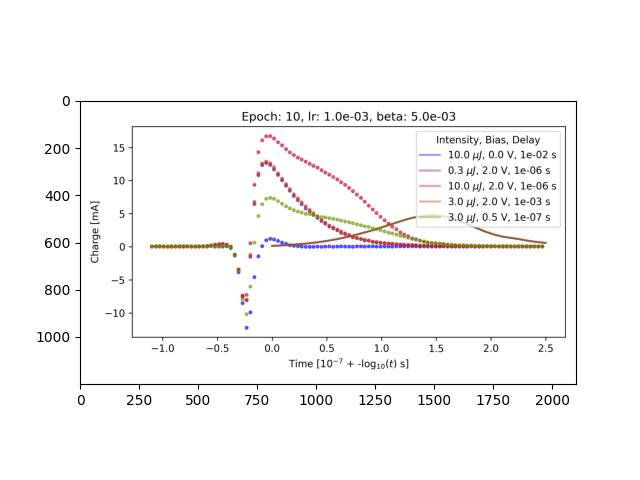

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\vscode\\python\\TOR-2024\\raymond-tor-dtml\\nbks\\saves\\default_run_default_20240202-174805\\gifs'

In [79]:
compile_learning_gif(model_params)

select fixed subset to sample in gif
save the model
record params
plot param changes along with gif
remove 1 second bias
